In [1]:
import collections
import itertools
import json
import datetime
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm

In [19]:
LANGUAGES = [
     #"rust",
    "python",
    "javascript",
    "java",
    "ruby",
    "r",
]

# Probability of a random post being a novelty

In [24]:
novelty_plots = {}
for language in LANGUAGES:
    print(f"Processing {language}...")
    path_to_lib = f"data/results/{language}"
    
    with open(f"{path_to_lib}/{language}_{language}_post_stats.json") as handle:
        post_stats = json.load(handle)
    sorted_post_stats = sorted(post_stats, key=lambda item:  datetime.datetime.strptime(item['date'], "%Y-%m-%dT%H:%M:%S.%f"))
    
    with open(f"{path_to_lib}/{language}_pairs_first_dates.json") as handle:
        pairs_first_dates = json.load(handle)
    
    with open(f"{path_to_lib}/{language}_all_pairs_dates.json") as handle:
        pairs_dates = json.load(handle)
    
    annual_post_count = collections.defaultdict(int)
    annual_novelty_count = collections.defaultdict(int)
    
    for post_stat in tqdm.tqdm(sorted_post_stats):
        year = post_stat["date"][:4]
        annual_post_count[year] += 1
        novelty_count = 0
        for imp1, imp2 in itertools.combinations(post_stat["imports"], 2):
            canonical_pair_name = "|".join(sorted([imp1, imp2]))
            if pairs_first_dates[canonical_pair_name]["id"] == post_stat["id"]:
                novelty_count += 1
        if novelty_count > 0:
            annual_novelty_count[year] += 1

    xs = list(annual_post_count.keys())
    ys = [n/max(1, t) for n, t in zip(annual_novelty_count.values(), annual_post_count.values())]
    novelty_plots[language] = ((xs, ys))

Processing python...


100%|█████████████████████████████| 1496348/1496348 [00:03<00:00, 472857.26it/s]


Processing javascript...


100%|███████████████████████████████| 233986/233986 [00:00<00:00, 464735.49it/s]


Processing java...


100%|███████████████████████████████| 315370/315370 [00:00<00:00, 871097.23it/s]


Processing ruby...


100%|█████████████████████████████████| 42756/42756 [00:00<00:00, 613424.76it/s]


Processing r...


100%|███████████████████████████████| 327074/327074 [00:00<00:00, 639834.68it/s]


(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35]),
 [Text(0, 0.0, '0.00'),
  Text(0, 0.05, '0.05'),
  Text(0, 0.1, '0.10'),
  Text(0, 0.15000000000000002, '0.15'),
  Text(0, 0.2, '0.20'),
  Text(0, 0.25, '0.25'),
  Text(0, 0.30000000000000004, '0.30'),
  Text(0, 0.35000000000000003, '0.35')])

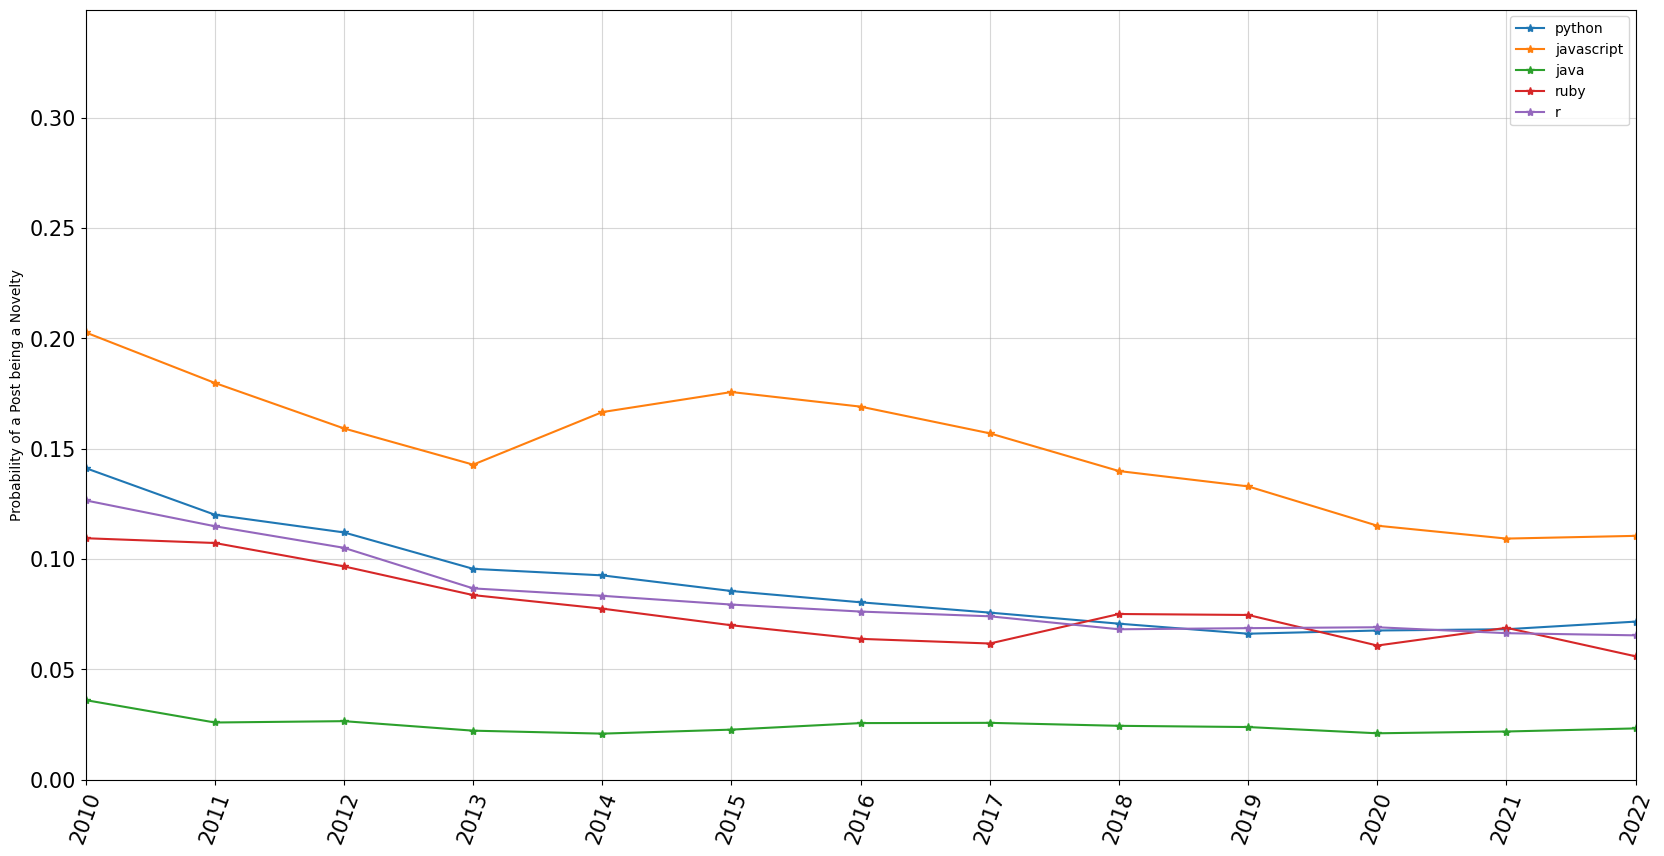

In [69]:
f, ax = plt.subplots(1)
f.set_figheight(10)
f.set_figwidth(20)
for lang in novelty_plots:
    ax.plot(*novelty_plots[lang], "-*", label=lang)
ax.legend()
ax.set_ylabel("Probability of a Post being a Novelty")
ax.grid(alpha = 0.5)
plt.xticks(rotation=70)
ax.set_ylim(ymin=0)
ax.set_xlim(["2010", "2022"])
plt.xticks(size=15)
plt.yticks(size=15)


# Probability of a random post being a valuable novelty

In [35]:
VALUE_THRESHOLD_RATIO = 0.0001
TIME_WINDOW = datetime.timedelta(days=365)

value_plots = {}
for language in LANGUAGES:
    print(f"Processing {language}...")
    path_to_lib = f"data/results/{language}"
    
    with open(f"{path_to_lib}/{language}_{language}_post_stats.json") as handle:
        post_stats = json.load(handle)
    sorted_post_stats = sorted(post_stats, key=lambda item:  datetime.datetime.strptime(item['date'], "%Y-%m-%dT%H:%M:%S.%f"))
    
    with open(f"{path_to_lib}/{language}_pairs_first_dates.json") as handle:
        pairs_first_dates = json.load(handle)
    
    with open(f"{path_to_lib}/{language}_all_pairs_dates.json") as handle:
        pairs_dates = json.load(handle)

    with open(f"{path_to_lib}/{language}_{language}_daily_post_stats.json") as handle:
        daily_post_stats = json.load(handle)
    
    annual_post_count = collections.defaultdict(int)
    annual_value_count = {str(year): 0 for year in range(2008, 2024)}


    # get cumulative_daily post_stats
    cumulative_daily_post_stats = {}
    runner = datetime.datetime(2008,1,1).date()
    while runner < datetime.datetime(2024,1,1).date():
        cumulative_daily_post_stats[runner] = 0
        runner += datetime.timedelta(days=1)
    summer = 0
    for k in cumulative_daily_post_stats:
        record = daily_post_stats.get(k.strftime("%Y-%m-%d"), 0)
        summer += record
        cumulative_daily_post_stats[k] = summer

    # Count valuable posts
    for post_stat in tqdm.tqdm(sorted_post_stats):
        year = post_stat["date"][:4]
        annual_post_count[year] += 1
        for imp1, imp2 in itertools.combinations(post_stat["imports"], 2):
            canonical_pair_name = "|".join(sorted([imp1, imp2]))
            if pairs_first_dates[canonical_pair_name]["id"] == post_stat["id"]:
                # novel post, we can assess if it is valuable
                relevant_dates = [
                    dt for dt in pairs_dates[canonical_pair_name]if (
                        datetime.datetime.strptime(dt, "%Y-%m-%d") <
                        datetime.datetime.strptime(pairs_first_dates[canonical_pair_name]["date"], "%Y-%m-%d") + TIME_WINDOW
                        )
                ]
                posts_in_interval = (
                    cumulative_daily_post_stats[
                        min(
                            datetime.datetime(2023,12,31),
                            datetime.datetime.strptime(post_stat["date"], "%Y-%m-%dT%H:%M:%S.%f") + datetime.timedelta(days=365),
                        ).date()
                    ] - 
                    cumulative_daily_post_stats[
                        (datetime.datetime.strptime(post_stat["date"], "%Y-%m-%dT%H:%M:%S.%f") - datetime.timedelta(days=1)).date()
                    ]
                )

            if len(relevant_dates) / max(1, posts_in_interval) > VALUE_THRESHOLD_RATIO:
                annual_value_count[year] += 1
                break

    xs = list(annual_post_count.keys())
    ys = [n/max(1, t) for n, t in zip(annual_value_count.values(), annual_post_count.values())]
    value_plots[language] = (xs, ys)

Processing python...


100%|██████████████████████████████| 1496348/1496348 [00:30<00:00, 49097.24it/s]


Processing javascript...


100%|████████████████████████████████| 233986/233986 [00:04<00:00, 53052.84it/s]


Processing java...


100%|███████████████████████████████| 315370/315370 [00:02<00:00, 119169.29it/s]


Processing ruby...


100%|█████████████████████████████████| 42756/42756 [00:00<00:00, 217738.30it/s]


Processing r...


100%|████████████████████████████████| 327074/327074 [00:04<00:00, 72772.79it/s]


(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.1, '0.1'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.30000000000000004, '0.3'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.5, '0.5'),
  Text(0, 0.6000000000000001, '0.6')])

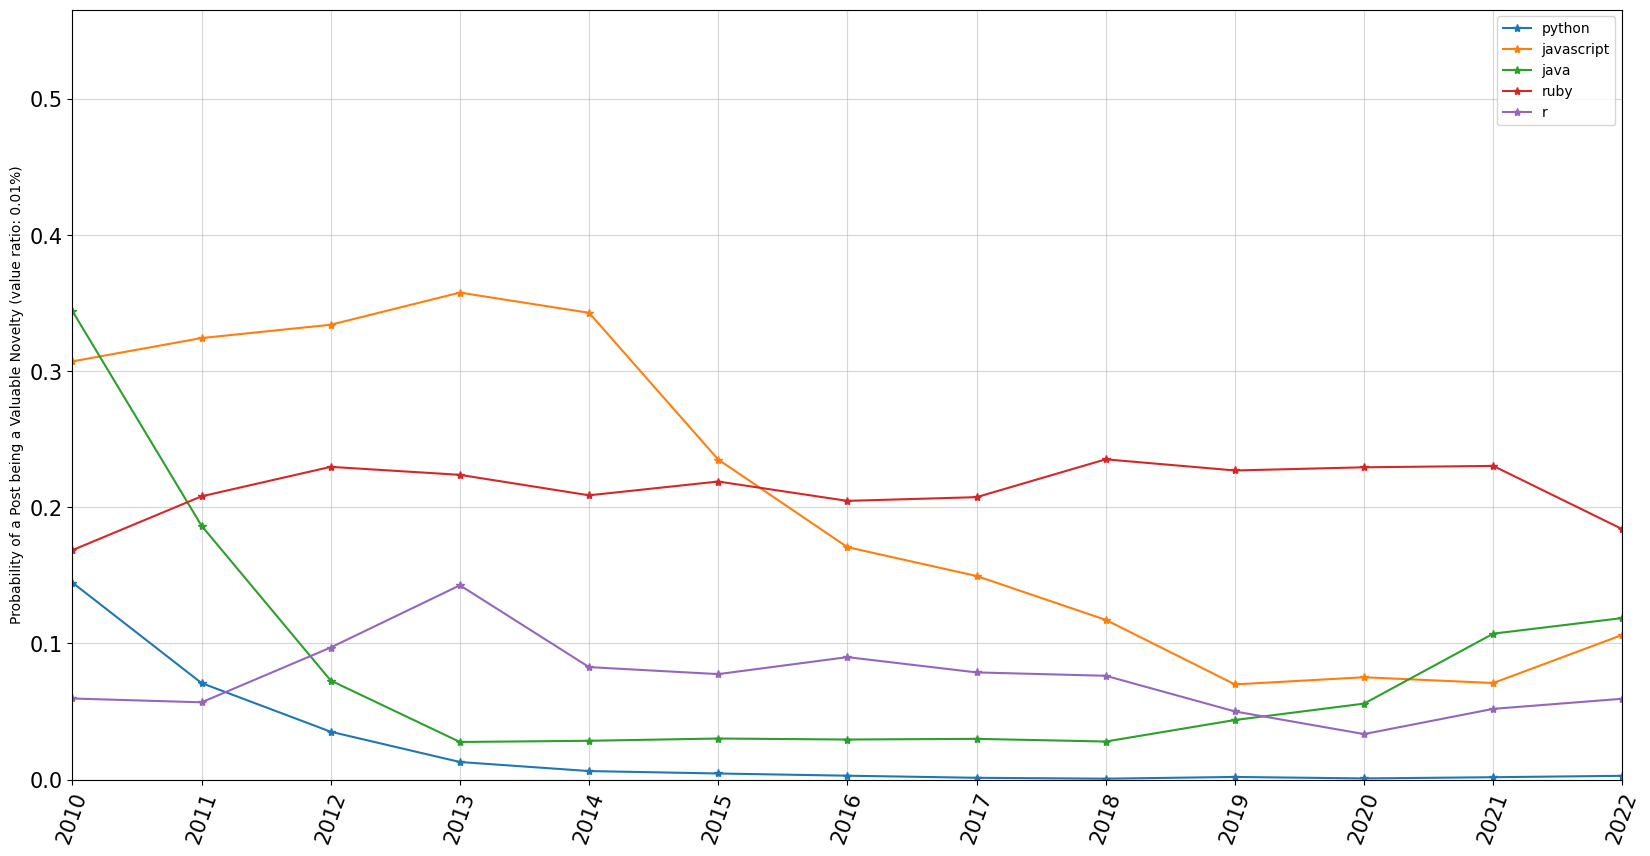

In [71]:
f, ax = plt.subplots(1)
f.set_figheight(10)
f.set_figwidth(20)
for lang in value_plots:
    ax.plot(*value_plots[lang], "-*", label=lang)
ax.legend()
ax.set_ylabel(f"Probability of a Post being a Valuable Novelty (value ratio: {100 * VALUE_THRESHOLD_RATIO}%)")
ax.grid(alpha = 0.5)
plt.xticks(rotation=70)
ax.set_ylim(ymin=0)
ax.set_xlim(["2010", "2022"])
plt.xticks(size=15)
plt.yticks(size=15)
